# Monte Carlo Congestion Simulation

Simulate low-voltage demand with random EV and solar panel adoption.

In [20]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
from tqdm import tqdm

sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))

# Import from src
from src.grid_model import generate_lv_grid
from src.simulate import generate_hourly_load_profiles_realistic
from src.visualize import compute_total_load

### Simulation parameters

Same simulation parameters as in simple model, but increasing transformer capacity to get more variation in congestion probability.

In [21]:
# Parameters
N_HOUSES = 50
HOURS = 24
TRANSFORMER_CAPACITY = 125  # kW
TRANSFORMER_ID = "TR_001"
DATA_DIR = "../data/generated"
PLOTS_DIR = "../data/plots"
RESULTS_FILE = f"{DATA_DIR}/monte_carlo_results.csv"
N_SIMULATIONS = 100

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)


Adding new technologies: charging posts for electric cars (EV) and solar panels (PV). Solar panels work during the day, assuming it's always sunny, like in California. Electric cars are recharged during evening hours, after people come back home from work.

In [22]:
# EV and Solar PV parameters
EV_LOAD = 2.5  # kW
EV_HOURS = range(18, 23)  # 18:00-22:00

PV_MAX_OUTPUT = 2.0  # kW
PV_HOURS = range(10, 17)  # 10:00-16:00

### Generate grid 

In [23]:
G = generate_lv_grid(N_HOUSES)
# Generate base load profiles
house_ids = list(G.nodes())

### Setting up helping functions

In [24]:
def add_technologies(base_profiles, n_ev, n_pv):
    """
    Add EVs and solar panels to random houses in the simulation.

    Randomly assigns electric vehicles and solar PV systems to houses
    and modifies their load profiles accordingly. EVs increase evening load
    while solar PV reduces daytime load.

    Parameters
    ----------
    base_profiles : pandas.DataFrame
        DataFrame containing base load profiles for all houses
    n_ev : int
        Number of houses to equip with electric vehicles
    n_pv : int
        Number of houses to equip with solar PV systems

    Returns
    -------
    pandas.DataFrame
        Modified load profiles with EV and PV impacts included
    """
    profiles = base_profiles.copy()
    profiles = profiles.loc[~profiles.index.str.startswith("transformer"), :]

    # Randomly select houses for each technology
    all_houses = profiles.index.tolist()
    ev_houses = np.random.choice(all_houses, size=n_ev, replace=False)

    # Select from all houses for PV (can have EV+PV)
    pv_houses = np.random.choice(all_houses, size=n_pv, replace=False)

    # Add EV load
    for house in ev_houses:
        for hour in EV_HOURS:
            profiles.loc[house, f"hour_{hour}"] += EV_LOAD

    # Subtract PV generation
    for house in pv_houses:
        for hour in PV_HOURS:
            # Scale PV output based on time of day (peak at noon)
            hour_factor = 1.0 - 0.3 * abs(hour - 12) / 3  # Peak at hour 12 (1pm)
            pv_output = PV_MAX_OUTPUT * hour_factor

            # Ensure load doesn't go negative
            current_load = profiles.loc[house, f"hour_{hour}"]
            profiles.loc[house, f"hour_{hour}"] = max(0.1, current_load - pv_output)

    return profiles

In [25]:
def run_monte_carlo_simulation(house_ids, max_ev=20, max_pv=20):
    """
    Run Monte Carlo simulations with varying technology adoption levels.

    Performs multiple simulations across different combinations of EV and PV
    adoption rates to assess congestion probability and peak load statistics.

    Parameters
    ----------
    house_ids : list
        List of house identifiers in the grid
    max_ev : int, default=20
        Maximum number of electric vehicles to consider
    max_pv : int, default=20
        Maximum number of solar PV systems to consider

    Returns
    -------
    pandas.DataFrame
        Results containing congestion probabilities and load statistics
        for each EV/PV combination
    """
    results = []

    # Create combinations of EV and PV counts
    ev_counts = list(range(0, max_ev + 1, 2))
    pv_counts = list(range(0, max_pv + 1, 2))

    # Progress bar
    total_combinations = len(ev_counts) * len(pv_counts)
    pbar = tqdm(total=total_combinations * N_SIMULATIONS, desc="Running simulations")

    for n_ev in ev_counts:
        for n_pv in pv_counts:
            congestion_count = 0
            peak_loads = []

            for sim in range(N_SIMULATIONS):
                base_load_profiles = generate_hourly_load_profiles_realistic(house_ids)
                # Add technologies to random houses
                modified_profiles = add_technologies(base_load_profiles, n_ev, n_pv)

                # Calculate total load
                total_load = compute_total_load(modified_profiles)

                # Check for congestion
                peak_load = total_load.max()

                peak_loads.append(peak_load)

                if peak_load > TRANSFORMER_CAPACITY:
                    congestion_count += 1

                pbar.update(1)

            # Record results
            congestion_probability = congestion_count / N_SIMULATIONS
            results.append(
                {
                    "n_ev": n_ev,
                    "n_pv": n_pv,
                    "congestion_probability": congestion_probability,
                    "avg_peak_load": np.mean(peak_loads),
                    "max_peak_load": np.max(peak_loads),
                    "min_peak_load": np.min(peak_loads),
                }
            )

    pbar.close()
    return pd.DataFrame(results)

### Run or load simulation results

In [26]:

if not os.path.exists(RESULTS_FILE):
    print(f"Results file {RESULTS_FILE} not found. Run the simulation first.")

    results = run_monte_carlo_simulation(house_ids, max_ev=20, max_pv=20)

    # Save results
    results.to_csv(f"{DATA_DIR}/monte_carlo_results.csv", index=False)
    print(f"Saved Monte Carlo results to {DATA_DIR}/monte_carlo_results.csv")
else:
    # Load results
    results = pd.read_csv(RESULTS_FILE)
    print(f"Loaded results with {len(results)} scenarios")

Loaded results with 121 scenarios


### Display summary statistics

In [27]:

print("\nSummary statistics:")
print(f"Average congestion probability: {results['congestion_probability'].mean():.2f}")
print(f"Maximum congestion probability: {results['congestion_probability'].max():.2f}")
print(f"Average peak load: {results['avg_peak_load'].mean():.2f} kW")


Summary statistics:
Average congestion probability: 0.69
Maximum congestion probability: 1.00
Average peak load: 135.46 kW


### Exploring qualitatve influence of EV and PV adoption on congestion probability

Solar panels work during daytime, reducing the load which is not large anyway. This makes practically no difference for congestion probability. On the other hand, EVs increase load close to the evening peak, increasing congestion probability.

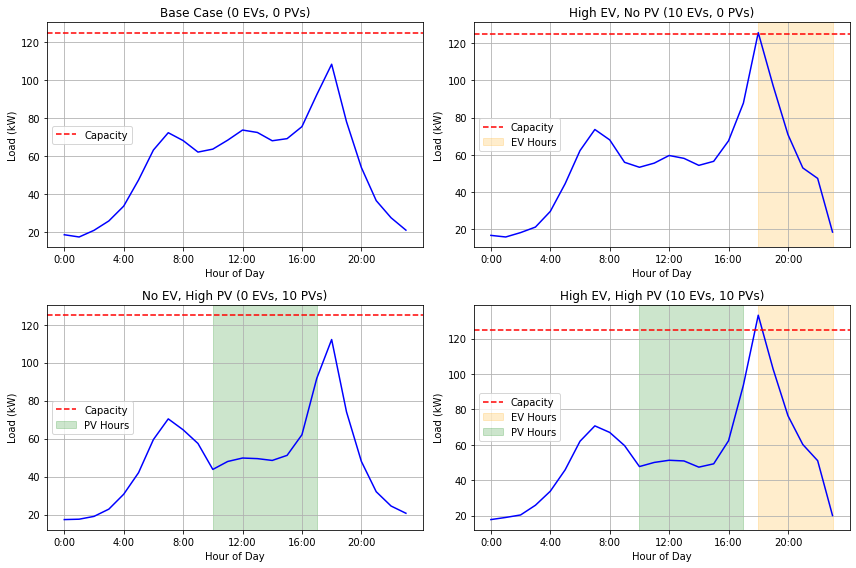

In [28]:
# Visualize example load scenarios
plt.figure(figsize=(12, 8))
# Get example scenarios
scenarios = [
    (0, 0, "Base Case"),
    (10, 0, "High EV, No PV"),
    (0, 10, "No EV, High PV"),
    (10, 10, "High EV, High PV"),
]

# Generate example load profiles for visualization
for i, (n_ev, n_pv, label) in enumerate(scenarios):
    # Generate a new load profile for this scenario
    base_load_profiles = generate_hourly_load_profiles_realistic(house_ids)
    modified_profiles = add_technologies(base_load_profiles, n_ev, n_pv)
    total_load = compute_total_load(modified_profiles)

    plt.subplot(2, 2, i + 1)
    plt.plot(range(HOURS), total_load, "b-")
    plt.axhline(TRANSFORMER_CAPACITY, color="r", linestyle="--", label="Capacity")

    # Highlight EV and PV hours
    if n_ev > 0:
        plt.axvspan(
            min(EV_HOURS),
            max(EV_HOURS) + 1,
            alpha=0.2,
            color="orange",
            label="EV Hours",
        )
    if n_pv > 0:
        plt.axvspan(
            min(PV_HOURS), max(PV_HOURS) + 1, alpha=0.2, color="green", label="PV Hours"
        )

    plt.title(f"{label} ({n_ev} EVs, {n_pv} PVs)")
    plt.xlabel("Hour of Day")
    plt.ylabel("Load (kW)")
    plt.xticks(range(0, HOURS, 4), [f"{h}:00" for h in range(0, HOURS, 4)])
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.savefig(f"{PLOTS_DIR}/07_MC_simulation_example_load_profiles.png")
plt.show()

### Plot congestion probability vs EV adoption (for different PV levels)
Regardless of PV level, EV has strong influence on congestion probability.

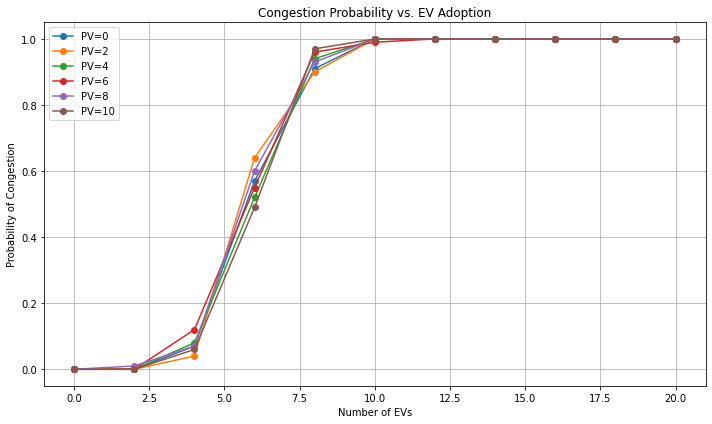

In [29]:

plt.figure(figsize=(10, 6))

for n_pv in [0, 2, 4, 6, 8, 10]:
    subset = results[results["n_pv"] == n_pv]
    plt.plot(
        subset["n_ev"], subset["congestion_probability"], marker="o", label=f"PV={n_pv}"
    )

plt.title("Congestion Probability vs. EV Adoption")
plt.xlabel("Number of EVs")
plt.ylabel("Probability of Congestion")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(f"{PLOTS_DIR}/04_MC_simulation_congestion_vs_ev.png")
plt.show()

### Plot congestion probability vs PV adoption (for different EV levels)
In these adoption scenarios, EVs do not influence congestion probability.

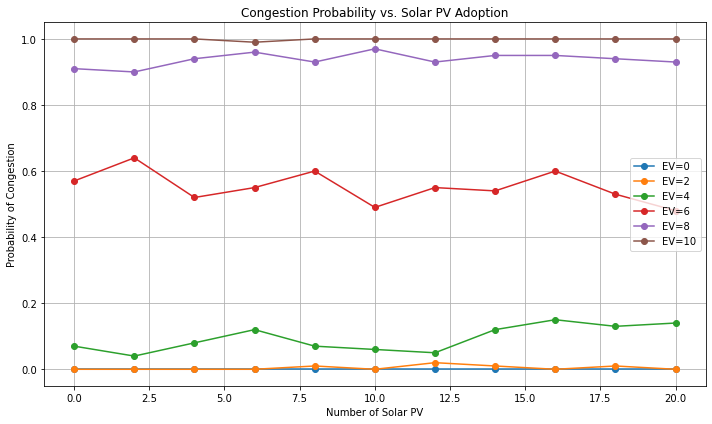

In [30]:

plt.figure(figsize=(10, 6))

for n_ev in [0, 2, 4, 6, 8, 10]:
    subset = results[results["n_ev"] == n_ev]
    plt.plot(
        subset["n_pv"], subset["congestion_probability"], marker="o", label=f"EV={n_ev}"
    )

plt.title("Congestion Probability vs. Solar PV Adoption")
plt.xlabel("Number of Solar PV")
plt.ylabel("Probability of Congestion")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(f"{PLOTS_DIR}/05_MC_simulation_congestion_vs_pv.png")
plt.show()

### Create a heatmap of congestion probability (EV vs PV)
Same as above, but on one plot.

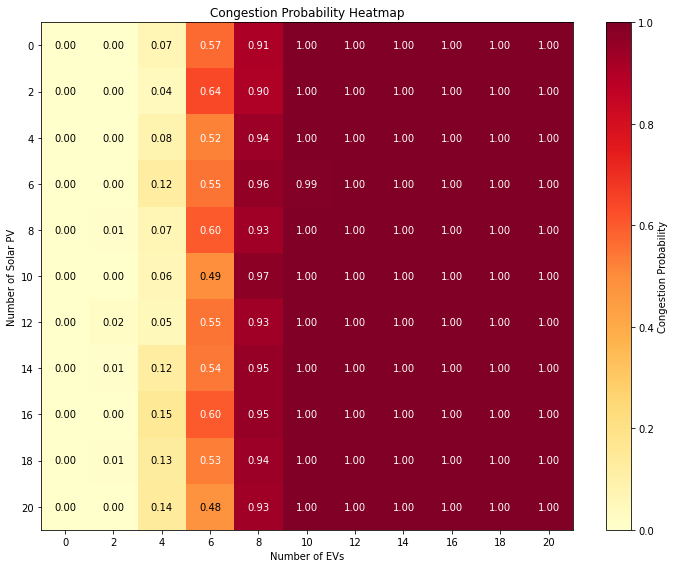

In [31]:

pivot_table = results.pivot(
    index="n_pv", columns="n_ev", values="congestion_probability"
)

plt.figure(figsize=(10, 8))
plt.imshow(pivot_table, cmap="YlOrRd", interpolation="nearest", aspect="auto")
plt.colorbar(label="Congestion Probability")
plt.title("Congestion Probability Heatmap")
plt.xlabel("Number of EVs")
plt.ylabel("Number of Solar PV")
plt.xticks(range(len(pivot_table.columns)), pivot_table.columns)
plt.yticks(range(len(pivot_table.index)), pivot_table.index)

# Add text annotations
for i in range(len(pivot_table.index)):
    for j in range(len(pivot_table.columns)):
        plt.text(
            j,
            i,
            f"{pivot_table.iloc[i, j]:.2f}",
            ha="center",
            va="center",
            color="black" if pivot_table.iloc[i, j] < 0.5 else "white",
        )

plt.tight_layout()
plt.savefig(f"{PLOTS_DIR}/06_MC_simulation_congestion_heatmap.png")
plt.show()